<a href="https://colab.research.google.com/github/dinisrferreira/Pseudodiagnosticity-in-a-continuous-learning-environment-Reis-2020-/blob/main/Data_generator_Reis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Bug conhecido: Os type 3 não contam mas estão a gerar corretamente

In [67]:
import random
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

In [68]:
class ConditionDataset:
    def __init__(self, environment="wicked", num_samples=1000, prob_no_decision=0.02):
        self.num_samples = num_samples
        self.prob_no_decision = prob_no_decision
        self.num_no_decision_samples = int(self.num_samples * self.prob_no_decision)

        self.wicked_conditions = {
            "Type 1": {
                'a': ('high', 'b'),        # S1 high, Disease A
                'b': ('high', None),       # S1 high, Disease B, but < a
                'c': ('high', 'd'),        # S2 high, Disease A
                'd': ('high', None)        # S2 high, Disease B, but < c
            },
            "Type 2": {
                'a': ('high', 'b'),        # S1 high, Disease A, but > b
                'b': ('high', None),       # S1 high, Disease B
                'c': ('high', None),       # S2 high, Disease A
                'd': ('low', None)         # S2 low, Disease B
            },
            "Type 3": {
                'a': ('high', 'b'),
                'b': ('high', None),
                'c': ('low', None),
                'd': ('low', 'c')
            },
            "Type 4": {
                'a': ('low', None),
                'b': ('high', None),
                'c': ('low', None),
                'd': ('high', None)
            }
        }

        if environment == "wicked":
            self.cell_types_conditions = self.wicked_conditions
        elif environment == "kind":
            self.cell_types_conditions = {
                "Type i": {
                    'a': ('high', None),
                    'b': ('high', 'a'),
                    'c': ('high', None),
                    'd': ('high', 'c')
                },
                "Type ii": {
                    'a': ('high', None),
                    'b': ('high', 'a'),
                    'c': ('low', None),
                    'd': ('high', None)
                },
                "Type iii": {
                    'a': ('high', None),
                    'b': ('high', 'a'),
                    'c': ('low', 'd'),
                    'd': ('low', None)
                }
            }

            # Comment: Introduce 5% of "wicked" samples into the "kind" environment
            self.num_wicked_samples_in_kind = int(self.num_samples * 0.05)
        else:
            raise ValueError("Invalid environment. Must be 'wicked' or 'kind'.")



        self.data = []
        self._generate_data(environment)


    def _generate_data(self, environment):
        initial_choices = ['a', 'b', 'c', 'd']
        num_types = len(self.cell_types_conditions)
        samples_per_type = (self.num_samples - self.num_no_decision_samples) // num_types

        if environment == "kind":
            # Comment: Generate 5% of samples using "wicked" conditions
            for _ in range(self.num_wicked_samples_in_kind):
                cell_type = random.choice(list(self.wicked_conditions.keys()))
                conditions = self.wicked_conditions[cell_type]
                initial_cell = random.choice(initial_choices)
                values = self._generate_values(conditions)
                input_vector = [0, 0, 0, 0]
                cell_index = {'a': 0, 'b': 1, 'c': 2, 'd': 3}
                input_vector[cell_index[initial_cell]] = values[initial_cell]
                diagnosis = self._calculate_diagnosis(values)
                self.data.append({
                    'input': input_vector,
                    'full_values': [values['a'], values['b'], values['c'], values['d']],
                    'label': diagnosis,
                    'initial_choice': cell_index[initial_cell]
                })

        # Generate samples for each type
        for cell_type, conditions in self.cell_types_conditions.items():
            for _ in range(samples_per_type):
                # Ensure equal distribution of initial cell choices
                initial_cell = random.choice(initial_choices)

                # Generate cell values based on type conditions
                values = self._generate_values(conditions)

                # Create input vector
                input_vector = [0, 0, 0, 0]
                cell_index = {'a': 0, 'b': 1, 'c': 2, 'd': 3}
                input_vector[cell_index[initial_cell]] = values[initial_cell]

                # Calculate the diagnosis label based on the most likely disease
                diagnosis = self._calculate_diagnosis(values)

                # Append the example to the dataset
                self.data.append({
                    'input': input_vector,
                    'full_values': [values['a'], values['b'], values['c'], values['d']],
                    'label': diagnosis,
                    'initial_choice': cell_index[initial_cell]
                })

        # Generate no-decision cases
        for _ in range(self.num_no_decision_samples):
            if random.choice([True, False]):
                a = random.randint(52, 94)
                b = random.randint(10, 43)
                values = {
                    'a': a,
                    'b': b,
                    'c': b,  # Ensuring a = d and b = c
                    'd': a
                }
            else:
                a = random.randint(10, 43)
                b = random.randint(52, 94)
                values = {
                    'a': a,
                    'b': b,
                    'c': b,  # Ensuring a = d and b = c
                    'd': a
                }

            initial_cell = random.choice(initial_choices)
            input_vector = [0, 0, 0, 0]
            cell_index = {'a': 0, 'b': 1, 'c': 2, 'd': 3}
            input_vector[cell_index[initial_cell]] = values[initial_cell]

            # Append the no-decision example to the dataset
            self.data.append({
                'input': input_vector,
                'full_values': [values['a'], values['b'], values['c'], values['d']],
                'label': 0,
                'initial_choice': cell_index[initial_cell]
            })


    def _generate_values(self, conditions):
        values = {}
        for cell, (level, ref_cell) in conditions.items():
            if level == 'high':
                values[cell] = random.randint(56, 90)
            elif level == 'low':
                values[cell] = random.randint(10, 43)
        # Process adjustments after initial value assignment
        for cell, (level, ref_cell) in conditions.items():
            if ref_cell and cell in values:  # Check if both cell and reference cell exist
                if level == 'high':
                    if conditions[ref_cell][0] == 'high':
                        values[cell] = random.randint(values[ref_cell] + 1, 98)
                    elif conditions[ref_cell][0] == 'low':
                        values[cell] = random.randint(56, 90) if values[ref_cell] < 70 else random.randint(70, min(98, values[ref_cell] + 25))
                elif level == 'low':
                    if conditions[ref_cell][0] == 'high':
                        values[cell] = random.randint(10, 43) if values[ref_cell] > 40 else random.randint(10, max(40, values[ref_cell] - 25))
                    elif conditions[ref_cell][0] == 'low':
                       # Ensure 'c' is lower than 'd' for type iii)
                        if cell == 'c' and ref_cell == 'd':
                            lower_bound = 10
                            upper_bound = max(lower_bound, values[ref_cell] - 1) # Adjust upper bound
                            values[cell] = random.randint(lower_bound, upper_bound)
                        else:
                        # Adjust the upper bound to be at least one greater than the lower bound
                          lower_bound = max(10, values[ref_cell] + 1)
                          values[cell] = random.randint(lower_bound, max(lower_bound + 1, 42))

        return values

    def _calculate_diagnosis(self, values):
        # Calculate the diagnosis based on Bayesian inference
        prob_disease_A = (values['a'] / (values['a'] + values['b'])) * (values['c'] / (values['c'] + values['d']))
        prob_disease_B = (values['b'] / (values['a'] + values['b'])) * (values['d'] / (values['c'] + values['d']))

        if prob_disease_A > prob_disease_B:
            return -1
        elif prob_disease_A < prob_disease_B:
            return 1
        else:
            return 0

    def get_data(self):
        return self.data


In [81]:
# Create the dataset
dataset = ConditionDataset(environment= 'wicked', num_samples=1000)


data = dataset.get_data()

In [82]:

def determine_type(example, kind_conditions, wicked_conditions):
    def check_conditions(conditions):
        for cell_type, cell_conditions in conditions.items():
            match = True
            for cell, (level, ref_cell) in cell_conditions.items():
                value = example['full_values'][ord(cell) - ord('a')]

                # Check the value against 'high' and 'low' thresholds
                if level == 'high' and value < 56:
                    match = False
                    break
                elif level == 'low' and value > 43:
                    match = False
                    break

                # Check the value against the reference cell value
                if ref_cell:
                    ref_value = example['full_values'][ord(ref_cell) - ord('a')]
                    if level == 'high' and value < ref_value:
                        match = False
                        break
                    elif level == 'low' and value > ref_value:
                        match = False
                        break

            if match:
                return cell_type
        return None

    # Check kind conditions first
    type_from_kind = check_conditions(kind_conditions)
    if type_from_kind is not None:
        return type_from_kind

    # Check wicked conditions if kind conditions do not match
    type_from_wicked = check_conditions(wicked_conditions)
    return type_from_wicked


def count_examples_by_type(data, kind_conditions, wicked_conditions):
    type_counts = Counter()
    for example in data:
        example_type = determine_type(example, kind_conditions, wicked_conditions)
        if example_type:
            type_counts[example_type] += 1
    return type_counts


In [83]:
def distribution_of_cell_values(data):
    cell_values = {'a': [], 'b': [], 'c': [], 'd': []}
    for example in data:
        values = example['full_values']
        cell_values['a'].append(values[0])
        cell_values['b'].append(values[1])
        cell_values['c'].append(values[2])
        cell_values['d'].append(values[3])
    return cell_values

def count_diagnoses(data):
    diagnosis_counts = Counter([example['label'] for example in data])
    return diagnosis_counts

def count_initial_choices(data):
    initial_choice_counts = Counter([example['initial_choice'] for example in data])
    return initial_choice_counts

def plot_cell_value_distribution(cell_values):
    for cell, values in cell_values.items():
        sns.histplot(values, bins=20, kde=True)
        plt.title(f'Distribution of Values for Cell {cell.upper()}')
        plt.xlabel('Value')
        plt.ylabel('Frequency')
        plt.show()

In [84]:
# Using the updated functions
type_counts = count_examples_by_type(data, dataset.cell_types_conditions, dataset.wicked_conditions)
print("Example Counts by Type:", type_counts)
print("---")


print(data[-10])

Example Counts by Type: Counter({'Type 1': 245, 'Type 2': 245, 'Type 4': 245})
---
{'input': [0, 0, 0, 32], 'full_values': [32, 94, 94, 32], 'label': 0, 'initial_choice': 3}


In [79]:
print("----")
print(data[5])
print(determine_type(data[5], dataset.cell_types_conditions, dataset.wicked_conditions))

----
{'input': [0, 56, 0, 0], 'full_values': [71, 56, 97, 81], 'label': -1, 'initial_choice': 1}
Type 1


In [80]:
example = {'input': [0, 0, 0, 42], 'full_values': [95, 56, 26, 42], 'label': -1, 'initial_choice': 3}
example_type = determine_type(example, dataset.cell_types_conditions, dataset.wicked_conditions)
print("Example Type:", example_type)


Example Type: None


Cell A Values Distribution: [86, 26, 85, 89, 83]
Cell B Values Distribution: [76, 65, 84, 83, 62]
Cell C Values Distribution: [65, 30, 31, 24, 32]
Cell D Values Distribution: [31, 75, 27, 38, 25]
Diagnosis Counts: Counter({1: 1002, -1: 26, 0: 20})
Initial Choice Counts: Counter({2: 283, 1: 265, 0: 262, 3: 238})


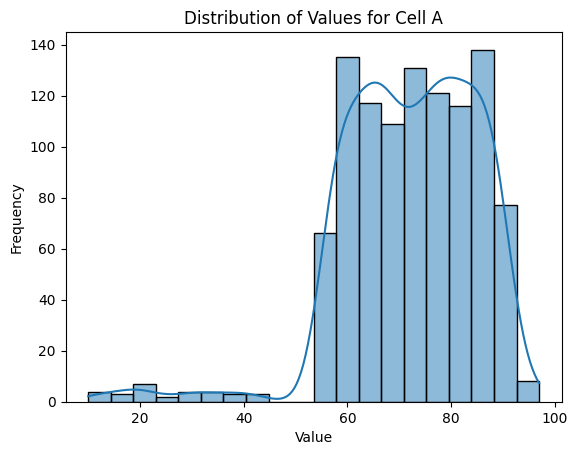

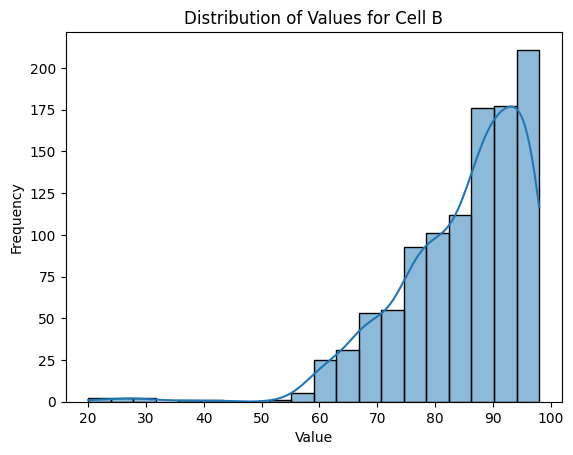

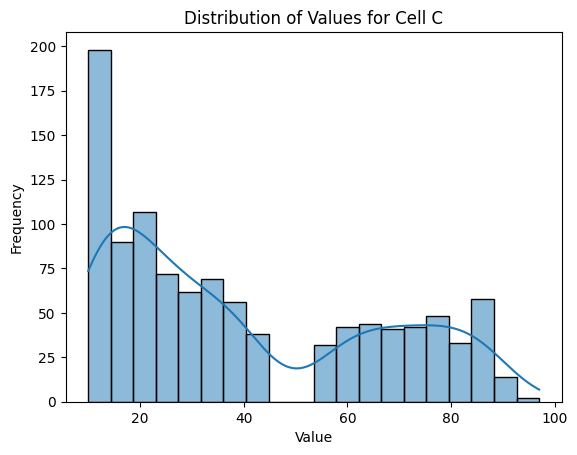

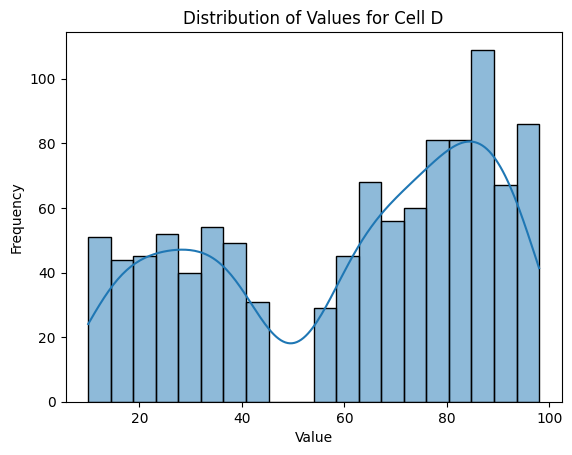

In [ ]:
# Distribution of cell values
cell_values = distribution_of_cell_values(data)
for cell, values in cell_values.items():
    print(f"Cell {cell.upper()} Values Distribution:", values[:5])  # Print first 5 values for brevity

# Count diagnoses
diagnosis_counts = count_diagnoses(data)
print("Diagnosis Counts:", diagnosis_counts)

# Count initial choices
initial_choice_counts = count_initial_choices(data)
print("Initial Choice Counts:", initial_choice_counts)

# Plot cell value distribution
plot_cell_value_distribution(cell_values)